In [2]:
import os
import datetime
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap
#import cv2
#from imutils import paths
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [62]:
# removing duplicate images from same lesion

df=pd.read_csv('skin-cancer-dataset/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['image_id',  'dx_type', 'age', 'sex', 'localization'], axis=1)
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
df.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
# how many images are there for each labels
lesion_counts = []
df_lesion = df['dx'].sort_values()
for label in labels:
    lesion_counts += [len(df[df['dx'] == label])]
    print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(lesion_counts)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
There are 151 images belong to akiec label
There are 175 images belong to bcc label
There are 440 images belong to bkl label
There are 39 images belong to df label
There are 230 images belong to mel label
There are 4415 images belong to nv label
There are 64 images belong to vasc label
[151, 175, 440, 39, 230, 4415, 64]


In [64]:
df=pd.read_csv('skin-cancer-dataset/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization'], axis=1)
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
# how many images are there for each labels
image_counts = []
df_image = df['dx'].sort_values()
for label in labels:
    image_counts += [len(df[df['dx'] == label])]
    print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(image_counts)


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
There are 327 images belong to akiec label
There are 514 images belong to bcc label
There are 1099 images belong to bkl label
There are 115 images belong to df label
There are 1113 images belong to mel label
There are 6705 images belong to nv label
There are 142 images belong to vasc label
[327, 514, 1099, 115, 1113, 6705, 142]


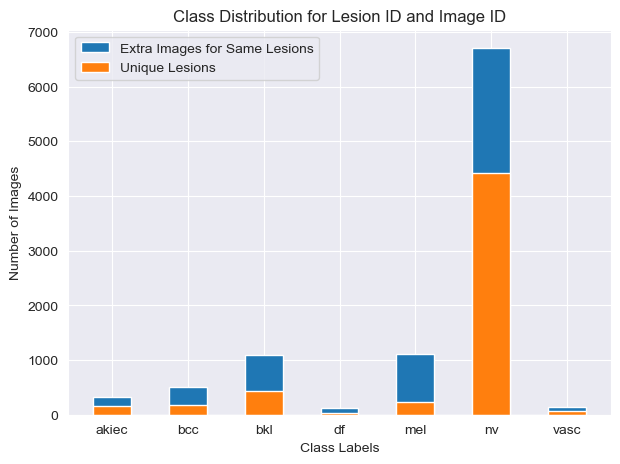

In [88]:
#plotting class distribution for lesion_id and image_id
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5)
bins = np.linspace(0 - .25, 6 + .25, 14)
ax.hist(df_image.values,bins=bins)
ax.hist(df_lesion.values,bins=bins)
ax.set_title("Class Distribution for Lesion ID and Image ID")
ax.set_xlabel('Class Labels')
ax.set_ylabel('Number of Images')
ax.legend(['Extra Images for Same Lesions', 'Unique Lesions'])
plt.savefig('class_distribution.png', dpi=300)

In [ ]:
'''
random.seed(42)
np.random.seed(42)
np.random.RandomState(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
'''

In [4]:
'''
grouped = df.groupby('dx')
for label in labels:
    drop_indices = []
    remove_n = grouped.get_group(label).shape[0] - 115 # number of images in the smallest class
    drop_indices = np.random.choice(grouped.get_group(label).index, remove_n, replace=False)
    df = df.drop(drop_indices) # drop extra images from original dataset
    '''

In [9]:
print(labels,'\n')
for label in labels:
    print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
df.sort_values(by=['image_id'], inplace=True)
df.head()

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'] 

There are 1099 images belong to bkl label
There are 6705 images belong to nv label
There are 115 images belong to df label
There are 1113 images belong to mel label
There are 142 images belong to vasc label
There are 514 images belong to bcc label
There are 327 images belong to akiec label


,image_id,dx
4349,ISIC_0024306.jpg,nv
4263,ISIC_0024307.jpg,nv
4217,ISIC_0024308.jpg,nv
3587,ISIC_0024309.jpg,nv
1451,ISIC_0024310.jpg,mel


In [10]:
train_df, test_df=train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx']) 
train_df, val_df=train_test_split(train_df, train_size=0.89, shuffle=True, random_state=123, stratify=train_df['dx'])

for label in labels:
    print("There are " + str(len(train_df[train_df['dx'] == label])) + " images belong to " + label + " label")
    print("There are " + str(len(val_df[val_df['dx'] == label])) + " images belong to " + label + " label")
    print("There are " + str(len(test_df[test_df['dx'] == label])) + " images belong to " + label + " label")
    

There are 880 images belong to bkl label
There are 109 images belong to bkl label
There are 110 images belong to bkl label
There are 5370 images belong to nv label
There are 664 images belong to nv label
There are 671 images belong to nv label
There are 92 images belong to df label
There are 11 images belong to df label
There are 12 images belong to df label
There are 892 images belong to mel label
There are 110 images belong to mel label
There are 111 images belong to mel label
There are 114 images belong to vasc label
There are 14 images belong to vasc label
There are 14 images belong to vasc label
There are 412 images belong to bcc label
There are 51 images belong to bcc label
There are 51 images belong to bcc label
There are 261 images belong to akiec label
There are 33 images belong to akiec label
There are 33 images belong to akiec label


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)
#rescale=1./255
# 600 x 450
# 200 x 150

target_size = (48, 48)
batch_size  = 32
train_set = train_datagen.flow_from_dataframe(train_df,
                                              directory="skin-cancer-dataset/Skin Cancer/Skin Cancer",
                                              x_col="image_id",
                                              y_col="dx",
                                              color_mode="grayscale",
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              )
val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_dataframe(val_df,
                                          directory="skin-cancer-dataset/Skin Cancer/Skin Cancer",
                                          x_col="image_id",
                                          y_col="dx",
                                          color_mode="grayscale",
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          )
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_dataframe(test_df,
                                            directory="skin-cancer-dataset/Skin Cancer/Skin Cancer",
                                            x_col="image_id",
                                            y_col="dx",
                                            color_mode="grayscale",
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            )



Found 8021 validated image filenames belonging to 7 classes.
Found 992 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


In [11]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64, kernel_size=(3,3), input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


#2nd CNN layer
model.add(Conv2D(32,(5,5),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#3rd layer
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

#4th layer
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))

#Last Layer
model.add(Dense(no_of_classes))
model.add(Activation('softmax'))


#model.add(Dropout(0.25))

model.compile(optimizer=Adam(learning_rate = 0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        51232     
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0

In [15]:
now = datetime.datetime.now().strftime("%d-%m-%H-%M")
os.mkdir(now)
# save last model variable to txt file
checkpoint = ModelCheckpoint(f"/Users/mehmet/Documents/vs-code/CS464-Introduction-to-Machine-Learning/Project/{now}/model-{now}.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit            (train_set,
                                #steps_per_epoch=50,
                                epochs=15,
                                validation_data = val_set,
                                #validation_steps = 15,
                                )

Epoch 1/15


2023-11-04 22:13:10.941600: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


251/251 [==============================] - 37s 147ms/step - loss: 1.0352 - accuracy: 0.6690 - val_loss: 1.3533 - val_accuracy: 0.6683
Epoch 2/15
251/251 [==============================] - 37s 145ms/step - loss: 0.9202 - accuracy: 0.6929 - val_loss: 1.0708 - val_accuracy: 0.6935
Epoch 3/15
251/251 [==============================] - 37s 146ms/step - loss: 0.8515 - accuracy: 0.7085 - val_loss: 1.1668 - val_accuracy: 0.6804
Epoch 4/15
251/251 [==============================] - 37s 146ms/step - loss: 0.8029 - accuracy: 0.7230 - val_loss: 1.0523 - val_accuracy: 0.6633
Epoch 5/15
251/251 [==============================] - 37s 148ms/step - loss: 0.7574 - accuracy: 0.7434 - val_loss: 1.0185 - val_accuracy: 0.6754
Epoch 6/15
251/251 [==============================] - 37s 149ms/step - loss: 0.6950 - accuracy: 0.7622 - val_loss: 0.9798 - val_accuracy: 0.6734
Epoch 7/15
251/251 [==============================] - 38s 151ms/step - loss: 0.6373 - accuracy: 0.7806 - val_loss: 1.0105 - val_accuracy: 0.6

In [51]:
with open('last.txt', 'w') as f:
    f.write(str(now))

model.save(f"/Users/mehmet/Documents/vs-code/CS464-Introduction-to-Machine-Learning/Project/{now}/model-{now}.h5")

# convert the history.history dict to a pandas DataFrame:
if type(history) is not pd.DataFrame:
    history = pd.DataFrame(history.history) 

# save to csv: 
hist_csv_file = f'{now}/history-{now}.csv'
with open(hist_csv_file, mode='w') as f:
    history.to_csv(f)

In [12]:
# read last model variable from txt file
now = open('last.txt', 'r').read()
model = load_model(f"/Users/mehmet/Documents/vs-code/CS464-Introduction-to-Machine-Learning/Project/{now}/model-{now}.h5")
history = pd.read_csv(f'{now}/history-{now}.csv')

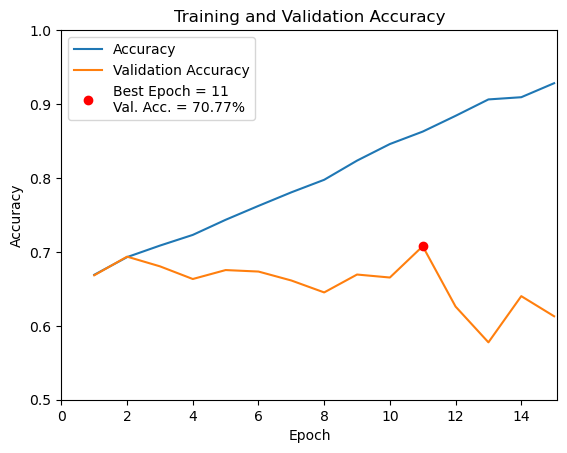

In [13]:
epochs = range(1, history.shape[0]+1)
plt.plot(epochs, history['accuracy'], label='Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
max_val_acc_epoch = np.argmax(history['val_accuracy']) + 1
max_val_acc = history['val_accuracy'][max_val_acc_epoch-1]
label='Best Epoch = '+str(max_val_acc_epoch)+'\nVal. Acc. = '+str((max_val_acc*100).round(2))+ '%'
plt.plot(max_val_acc_epoch, max_val_acc, 'ro', label=label)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0, history.shape[0]+0.1])
plt.ylim([0.5, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')

plt.savefig(f'{now}/val-acc-{now}.png')

In [212]:
print(test_set.class_indices)
print(test_set.classes[:5])
print(test_set.filenames[:5])
print('\n PREDICTING LABELS OF TEST IMAGES')
result = model.predict(test_set)
y_pred = np.argmax(result, axis=1)
print(y_pred)
#save y_pred to csv file
np.savetxt(f'{now}/pred-{now}.csv', y_pred, delimiter=',', fmt='%d')

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
[2, 4, 5, 5, 5]
['ISIC_0028681.jpg', 'ISIC_0025450.jpg', 'ISIC_0026162.jpg', 'ISIC_0026985.jpg', 'ISIC_0033420.jpg']

 PREDICTING LABELS OF TEST IMAGES
32/32 [==============================] - 4s 124ms/step
[4 2 5 ... 2 5 3]


In [14]:
# read y_pred from csv file
y_pred = np.loadtxt(f'{now}/pred-{now}.csv', delimiter=',', dtype=int)
y_pred

array([4, 2, 5, ..., 2, 5, 3])

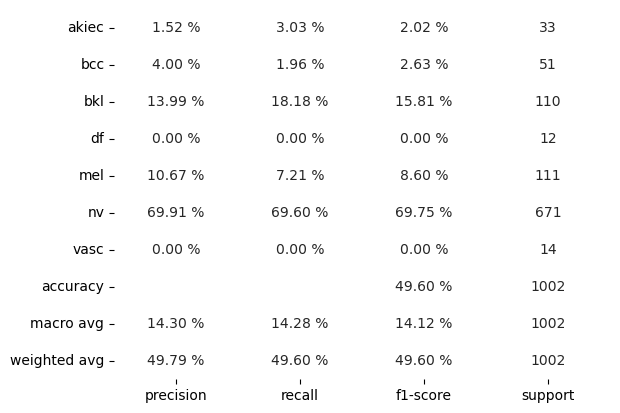

In [18]:
y_true = test_set.classes # List containing true labels for each image.

# Understanding classification power of model on each class    
report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())
report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=test_set.class_indices.keys())).transpose()
report_d['support']['accuracy'] = report_d['support']['macro avg']


annot = report_d.copy()
annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
annot.iloc[7, 1] = ''
annot.iloc[7, 0] = ''
annot['support'] = annot['support'].astype(int)

# how to save report as image
norm = Normalize(-1,1)
cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
fig = plot.get_figure()
fig.savefig(f'{now}/report-{now}.png')

F1-score of model prediction is: 49.60 %


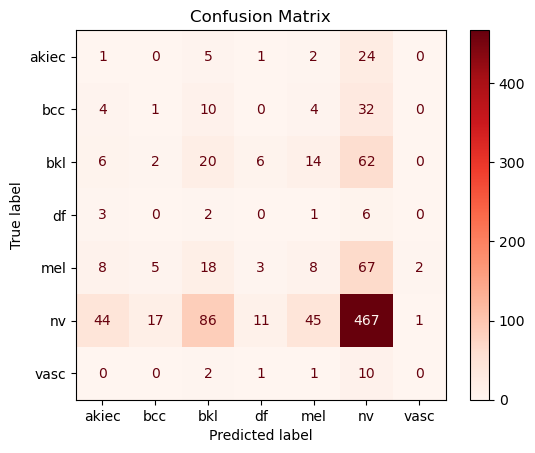

In [26]:
f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
print('F1-score of model prediction is: {:.2f} %'.format(f1_score))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_set.class_indices.keys()
                              )
disp.plot(cmap='Reds')
disp.ax_.set_title('Confusion Matrix')
disp.figure_.savefig(f'{now}/confusion-matrix-{now}.png')